In [1]:
from mallworld import MallWorld
import numpy as np
import time

In [2]:
mall_grid = MallWorld.samples["Three floors"]
task = MallWorld(maze = mall_grid, num_advs=3, 
                 rewards = {"moved":-1, "*":200, "hit-wall":-2, "runinto-people":-30, "stair":-1,"stay":-1})

In [3]:
task.reset()
task.visualize()
for i in task.adversaries_position:
    print(task.maze.unflatten_index(i))
    print(i)

#########
#......%#
#.......#
#..#.a..#
#..#....#
#.......#
#.#.....#
#%#...I.#
#########

#########
#%.....%#
#..######
#..#....#
#..#....#
#.......#
#####...#
#%.....%#
#########

#########
#%......#
#..######
#..#...*#
#..#....#
#.......#
#####.aa#
#......%#
#########
(2, 6, 6)
222
(2, 6, 7)
223
(0, 3, 5)
32


In [4]:
task.vol

243

In [5]:
print task.perform_action_adversary_rand(0)
task.visualize()

((60, array([222, 223,  23], dtype=int64)), -1, 0)
#########
#......%#
#....a..#
#..#....#
#..#....#
#.......#
#.#...I.#
#%#...o.#
#########

#########
#%.....%#
#..######
#..#....#
#..#....#
#.......#
#####...#
#%.....%#
#########

#########
#%......#
#..######
#..#...*#
#..#....#
#.......#
#####.aa#
#......%#
#########


In [28]:
initial_q = 0
num_iterations = 10000
num_episodes = 500
gamma = 0.95
alpha = 0.4
epsilon = 0.1

In [29]:
num_levels = task.maze.shape[0]

In [30]:
num_options_level = np.zeros(num_levels)
for key, value in task.climb.iteritems():
    for l in xrange(num_levels):
        if key<task.area*(l+1):
            num_options_level[l]+=1
            break

In [31]:
max_option = np.max(num_options_level)
options = np.zeros((num_levels,max_option))
count = np.zeros(num_levels)
for key, value in task.climb.iteritems():
    for l in xrange(num_levels):
        if key<task.area*(l+1):
            options[l,count[l]] = value
            count[l] +=1
            break

In [32]:
def epsilon_greedy(Q, task, cur_state, num_option=0):
    cur_action = Q[cur_state][0:task.num_actions+num_option].argmax()
    if(np.random.uniform()<epsilon):
        cur_action = np.random.randint(0, task.num_actions+num_option)
    
    return cur_action

In [47]:
reward_iter = []    # Immediate Reward by Iteration
reward_epi = []       # Immediate Reward by Episode

num_iter = 0
num_epi = 0

begin = time.time()

Q = np.full((3796875, task.num_actions+max_option), initial_q)  # Initialize action value function for this trial
while (num_iter<num_iterations)|(num_epi<num_episodes):
    task.reset()                            # reset to origin
    cur_state = task.get_current_situation()[0]
    states = []
    
    # Choose action from 0.1-policy
    l = task.observe()[0]/task.area
    cur_action = epsilon_greedy(Q, task, cur_state, num_options_level[l])
        
    tmp_reward_epi = 0                      # Cumulative reward of this episode

    while not task.is_terminal(cur_state%(num_levels*task.area)): # while-loop until current state is terminal state or reach maximum iterations
        # find whether this is an option
        count = 0
        if cur_action >= task.num_actions: # if this is option
            
            #print(cur_action)
            
            op = cur_action - task.num_actions
            level = l
            op_total_reward = 0
            
            print "Option Start",
            #print task.observe(),
            #print options[level, op], level
            
            op_cur_state = task.get_current_situation()[0]
            op_cur_action = epsilon_greedy(Q, task, op_cur_state, 0)
            tmp_reward_epi = 0
            
            while (op_cur_state%(num_levels*task.area)) != options[level, op] and\
                    not task.is_terminal(op_cur_state%(num_levels*task.area)) and count<1000:
                #if num_epi>9:
                #print op_cur_state%(num_levels*task.area),
                op_reward = task.perform_action_adversary_w_policy(op_cur_action)[1]
                op_new_state = task.get_current_situation()[0]
                
                states.append(op_new_state)
                
                reward_iter.append(op_reward)
                tmp_reward_epi += op_reward
                op_total_reward += gamma**count*op_reward
                
                num_iter += 1
                count += 1
                
                op_new_action = epsilon_greedy(Q, task, op_new_state, 0)
                
                Q[op_cur_state, op_cur_action] += \
                alpha*(op_reward + gamma*Q[op_new_state, Q[op_new_state][:task.num_actions].argmax()] - Q[op_cur_state, op_cur_action])
                if task.climb.has_key(op_cur_state%task.area):
                    dif = op_cur_state%task.area-task.climb[op_cur_state%task.area]
                    Q[op_cur_state+dif, op_cur_action] = Q[op_cur_state, op_cur_action]
                
                op_cur_state = op_new_state
                op_cur_action = op_new_action
                
            new_action = op_cur_action
            new_state = op_cur_state
            reward = op_total_reward
            
            print "Option End",
            #print(new_state%243)
            #print(new_action)
        
        # if it is not option
        else:
            #if num_epi>9:
                #print cur_state%162,
            reward = task.perform_action_adversary_w_policy(cur_action)[1]   # Take action and observe reward and new state
            new_state = task.get_current_situation()[0]
            
            states.append(new_state)
            
            reward_iter.append(reward)
            tmp_reward_epi += reward

            num_iter += 1
            count +=1
            l = task.observe()[0]/task.area
            new_action = epsilon_greedy(Q, task, new_state, num_options_level[l])    # Choose action from 0.1-policy
            
        Q[cur_state, cur_action] += \
        alpha*(reward + gamma**(count)*Q[new_state, Q[new_state].argmax()] - Q[cur_state, cur_action])
        
        if task.climb.has_key(cur_state%task.area):
            dif = cur_state%task.area - task.climb[cur_state%task.area]
            Q[cur_state+dif, cur_action] = Q[cur_state, cur_action]
        
        cur_state = new_state
        cur_action = new_action
    reward_epi.append(tmp_reward_epi)

    num_epi += 1
    print "Episode End",num_epi
print(time.time()-begin)

Option Start Option End Episode End 1
Option Start Option End Option Start Option End Option Start Option End Option Start Option End Episode End 2
Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Episode End 3
Option Start Option End Option Start Option End Option Start Option End Episode End 4
Option Start Option End Option Start Option End Option Start Option End Option Start Option End Episode End 5
Option Start Option End Episode End 6
Option Start Option End Episode End 7
Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Option Start Option End Episode End 8
Option Start Option End Episode End 9
Option Start Option End Option Sta

KeyboardInterrupt: 

In [ ]:
#print states[-1]%243
task.is_terminal(196)

In [42]:
op_reward + gamma*Q[op_new_state, Q[op_new_state].argmax()] - Q[op_cur_state, op_cur_action]

-1.1102230246251565e-16

In [44]:
op_reward + gamma*Q[op_new_state, Q[op_new_state].argmax()]

-1.0

In [48]:
num_iter

69308

In [45]:
op_new_state

51.0

In [38]:
task.get_current_situation()[0]%81

51.0

In [52]:
import matplotlib.pyplot as plt
% matplotlib inline

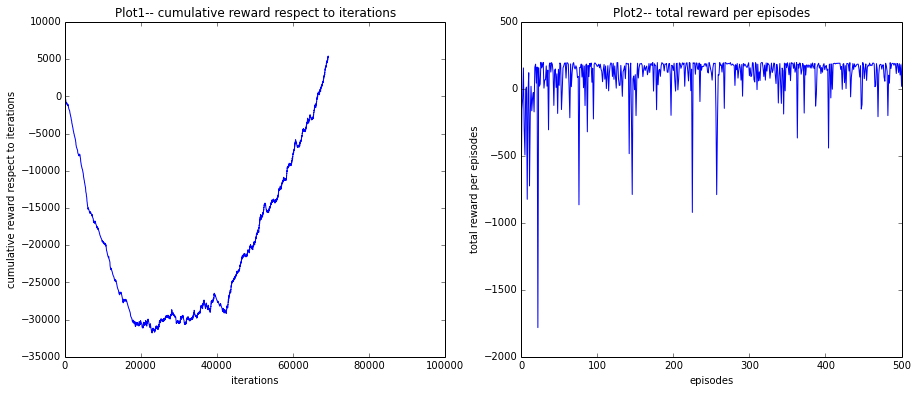

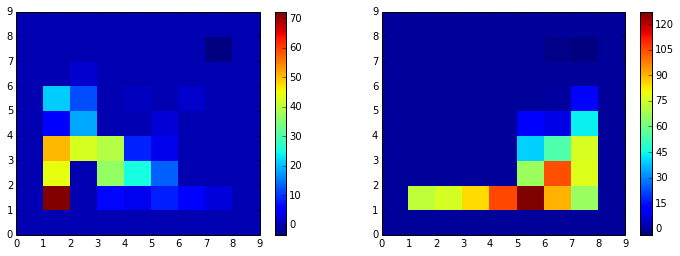

In [53]:
#MIN_ITERATIONS = num_iterations
MIN_ITERATIONS=100000
MIN_EPISODES = num_episodes

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cum_reward_iter = np.cumsum(reward_iter, axis=0)
plt.plot(cum_reward_iter,color='b')

plt.xlabel('iterations')
plt.ylabel('cumulative reward respect to iterations')
plt.xlim([0,MIN_ITERATIONS])
plt.title('Plot1-- cumulative reward respect to iterations')

plt.subplot(1,2,2)
plt.plot(reward_epi, color='b')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(Q[:81].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

plt.subplot(1,2,2)
plt.pcolormesh(Q[81:162].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

In [17]:
task.visualize()

#########
#......%#
#.......#
#..#....#
#..#....#
#.......#
#.#.....#
#%#...o.#
#########

#########
#%a....%#
#..######
#..#....#
#..#....#
#.......#
#####...#
#%aa...%#
#########

#########
#%....I.#
#..######
#..#...*#
#..#....#
#.......#
#####...#
#......%#
#########
